In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp


Matplotlib created a temporary cache directory at /jobfs/147909090.gadi-pbs/matplotlib-6l7tp1m6 because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# import matplotlib.ticker as mticker

In [3]:
# Tick formatting
import matplotlib.ticker as mticker#import MaxNLocator

In [4]:

# ---- Settings ----
alpha = 0.05
c_alpha = 1.358101515  # KS asymptotic constant for alpha=0.05
rep_factors = np.arange(1, 10)  # n per group = 20 * r

rng = np.random.default_rng(42)
x0 = rng.normal(0, 1, 20)
y0 = rng.normal(0, 1, 20)

# ---- Collect data ----
ns, pvals, dcrit = [], [], []
rep_series = []  # (label, array) for plotting
ks_val_list = []

for r in rep_factors:
    x = np.tile(x0, r)
    y = np.tile(y0, r)
    n = len(x)

    ns.append(n)
    ks_val = ks_2samp(x, y, alternative="two-sided", mode="asymp")
    ks_val_list.append(ks_val.statistic)
    pvals.append(ks_val.pvalue)
    dcrit.append(c_alpha * np.sqrt(2.0 / n))

    rep_series.append(("rep=" + str(r), x))
    rep_series.append(("rep=" + str(r), y))

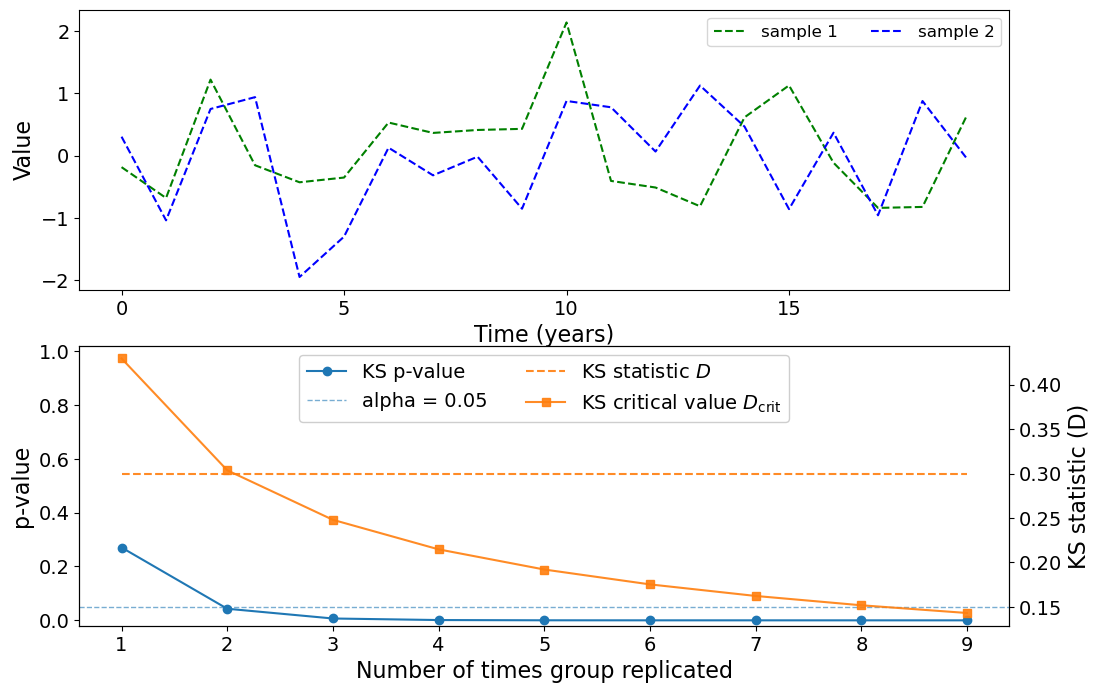

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ---- Figure: two rows ----
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12, 8))

# Row 1: all replicated series (solid = x, dashed = y)
ax_top.plot(y0, linestyle='--', color='green', label='sample 1')
ax_top.plot(x0, linestyle='--', color='blue', label='sample 2')
ax_top.set_xlabel("Time (years)", fontsize=16)
ax_top.set_ylabel("Value", fontsize=16)
ax_top.legend(ncol=4, fontsize=12)
ax_top.tick_params(axis='both', labelsize=14)
ax_top.xaxis.set_major_locator(mticker.MultipleLocator(5))

# Row 2: left y-axis = p-values, right y-axis = KS statistics
ax_left = ax_bottom
ax_right = ax_bottom.twinx()

x_values = (np.array(ns) / 20).astype(int)

ax_left.plot(x_values, pvals, marker='o', color='tab:blue', label='KS p-value')
ax_left.axhline(alpha, linestyle='--', linewidth=1, color='tab:blue', alpha=0.6,
                label=f'alpha = {alpha}')

# KS statistic and critical value (different colors, clean labels)
ax_right.plot(x_values, ks_val_list, linestyle='--',
              label=r'KS statistic $D$', alpha=0.9, color='tab:orange')
ax_right.plot(x_values, dcrit, marker='s', linestyle='-',
              label=r'KS critical value $D_{\mathrm{crit}}$', alpha=0.9, color='tab:orange')

ax_left.set_xlabel("Number of times group replicated", fontsize=16)
ax_left.set_ylabel("p-value", fontsize=16)
ax_left.set_ylim(-0.02, 1.02)
ax_right.set_ylabel(r"KS statistic (D)", fontsize=16)

# One combined legend (avoids overlap)
lines_left, labels_left = ax_left.get_legend_handles_labels()
lines_right, labels_right = ax_right.get_legend_handles_labels()
ax_right.legend(lines_left + lines_right,
                labels_left + labels_right,
                loc='upper center', fontsize=14, ncol=2, framealpha=0.95, facecolor='white')

ax_left.tick_params(axis='both', labelsize=14)
ax_right.tick_params(axis='both', labelsize=14)
ax_left.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))



Params: alpha=0.01, N1=3000, N2=1000, R=100, K=0.6, persist=2, trend_per_year=0.01, D_crit=0.052
ToE year: 1862


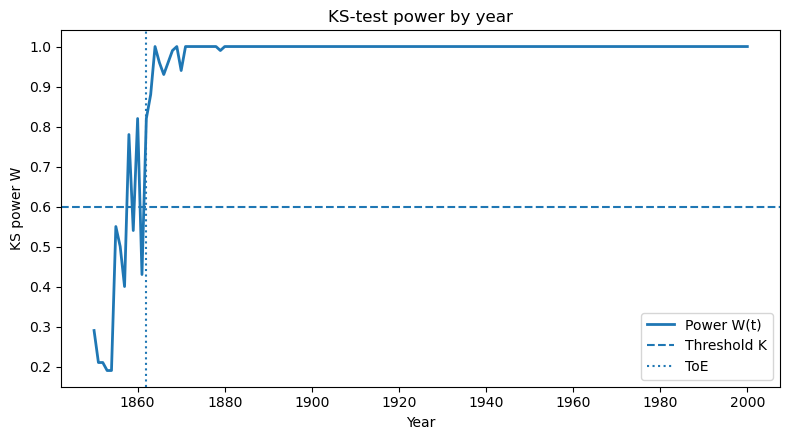

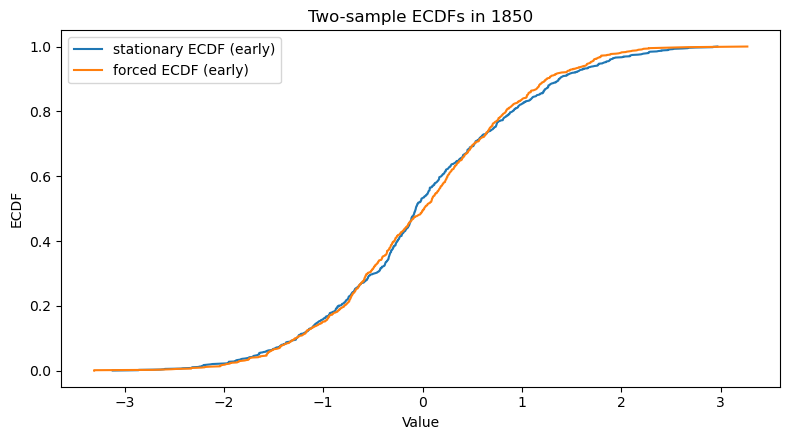

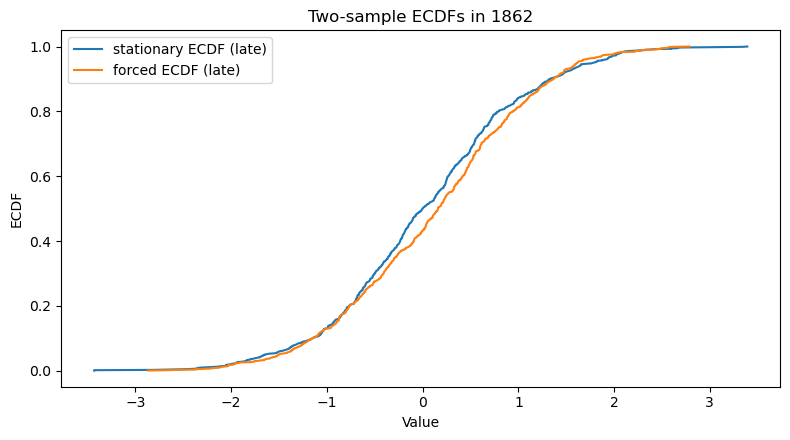

In [6]:
# KS-power ToE demo (single Jupyter cell)
# -----------------------------------------------------------
# What it does
# - Build stationary vs forced pools year-by-year
# - Bootstrap KS tests (alpha=0.01) to estimate power W(t)
# - Call ToE as first year with W(t) >= K and a persistence rule
# - Plot power curve + two ECDF overlays (early vs late)
#
# Tweak only the CONFIG block.

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# CONFIG
# ----------------------------
ALPHA = 0.01      # KS significance level (for Massey-style critical distance)
N1    = 3000      # pool size per year per generator
N2    = 1000      # per-test sample size (drawn with replacement)
R     = 100       # repetitions per year
K     = 0.60      # power threshold to call ToE
PERSIST_YEARS = 2 # require >=K for this many consecutive years

START_YEAR = 1850
N_YEARS    = 151                         # 1850..2000 inclusive (change as needed)
YEARS      = np.arange(START_YEAR, START_YEAR + N_YEARS)

# Synthetic forced signal: mean shift growing linearly with time.
# Change TREND_PER_YEAR to see earlier/later ToE.
TREND_PER_YEAR = 0.01

# Noise model (baseline SD); keep fixed if you want ToE "vs a fixed reference".
BASELINE_SD = 1.0

# Random seed for reproducibility
SEED = 12345

# ----------------------------
# KS helpers
# ----------------------------
# Paper-style critical distance at alpha=0.01 (Massey, c ≈ 1.63).
# This matches the text you pasted: d_alpha = 1.63/sqrt(N2) ≈ 0.05 for N2 ~ 1000
C_ALPHA = 1.63
CRITICAL = C_ALPHA / np.sqrt(N2)

def ks_d_stat(x: np.ndarray, y: np.ndarray) -> float:
    """Two-sample KS D statistic (no SciPy dependency)."""
    x = np.sort(x); y = np.sort(y)
    nx = x.size; ny = y.size
    z  = np.concatenate([x, y])
    z.sort()
    Fx = np.searchsorted(x, z, side="right") / nx
    Fy = np.searchsorted(y, z, side="right") / ny
    return float(np.max(np.abs(Fx - Fy)))

def ks_reject(x: np.ndarray, y: np.ndarray, critical: float) -> bool:
    """Reject H0 if D > critical."""
    return ks_d_stat(x, y) > critical

# ----------------------------
# Build pools (stationary vs forced)
# ----------------------------
rng = np.random.default_rng(SEED)

# Stationary pools do NOT evolve in time
baseline_pools = rng.normal(loc=0.0, scale=BASELINE_SD, size=(N_YEARS, N1))

# Forced pools: same variance, time-varying mean shift
forced_pools = np.empty_like(baseline_pools)
for i, year in enumerate(YEARS):
    mu = (year - START_YEAR) * TREND_PER_YEAR
    forced_pools[i] = rng.normal(loc=mu, scale=BASELINE_SD, size=N1)

# ----------------------------
# Bootstrap power by year
# ----------------------------
power = np.zeros(N_YEARS, dtype=float)
for i in range(N_YEARS):
    rejections = 0
    for _ in range(R):
        idx_base = rng.integers(0, N1, size=N2)
        idx_forc = rng.integers(0, N1, size=N2)
        x = baseline_pools[i, idx_base]
        y = forced_pools[i, idx_forc]
        if ks_reject(x, y, CRITICAL):
            rejections += 1
    power[i] = rejections / R

# ----------------------------
# Call ToE with persistence rule
# ----------------------------
toe_year = None
if PERSIST_YEARS <= 1:
    # first year at/above K
    hit = np.where(power >= K)[0]
    if hit.size:
        toe_year = int(YEARS[hit[0]])
else:
    # require PERSIST_YEARS consecutive years at/above K
    streak = 0
    for i in range(N_YEARS):
        if power[i] >= K:
            streak += 1
            if streak >= PERSIST_YEARS:
                toe_year = int(YEARS[i - PERSIST_YEARS + 1])
                break
        else:
            streak = 0

print(
    f"Params: alpha={ALPHA}, N1={N1}, N2={N2}, R={R}, "
    f"K={K}, persist={PERSIST_YEARS}, trend_per_year={TREND_PER_YEAR}, "
    f"D_crit={CRITICAL:.3f}"
)
print(f"ToE year: {toe_year}")

# ----------------------------
# Plot: power vs year
# ----------------------------
plt.figure(figsize=(8, 4.5))
plt.plot(YEARS, power, linewidth=2, label="Power W(t)")
plt.axhline(K, linestyle="--", linewidth=1.5, label="Threshold K")
if toe_year is not None:
    plt.axvline(toe_year, linestyle=":", linewidth=1.5, label="ToE")
plt.xlabel("Year")
plt.ylabel("KS power W")
plt.title("KS-test power by year")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# Plot: ECDFs for early vs late year
# ----------------------------
def ecdf(v: np.ndarray):
    v = np.sort(v)
    n = v.size
    y = np.arange(1, n + 1) / n
    return v, y

early_i = 0
late_i  = np.clip((toe_year - START_YEAR) if toe_year is not None else 80, 0, N_YEARS - 1)

for i, tag in [(early_i, "early"), (late_i, "late")]:
    idx_base = rng.integers(0, N1, size=N2)
    idx_forc = rng.integers(0, N1, size=N2)
    xb = baseline_pools[i, idx_base]
    yf = forced_pools[i,   idx_forc]
    xv, xec = ecdf(xb)
    yv, yec = ecdf(yf)

    plt.figure(figsize=(8, 4.5))
    plt.plot(xv, xec, label=f"stationary ECDF ({tag})")
    plt.plot(yv, yec, label=f"forced ECDF ({tag})")
    plt.xlabel("Value")
    plt.ylabel("ECDF")
    plt.title(f"Two-sample ECDFs in {YEARS[i]}")
    plt.legend()
    plt.tight_layout()
    plt.show()


KS power (block bootstrap): 1.000   |  D_crit=0.052  |  block_len=5, N2=1000, R=100


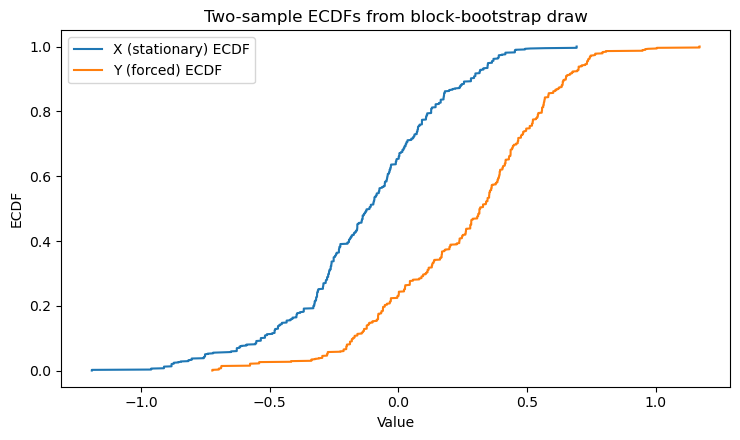

In [7]:
# KS test with BLOCK BOOTSTRAP (power estimation)
# ----------------------------------------------------------
# What it does
# - block-bootstrap re-samples from two input series (X, Y)
# - runs the two-sample KS test R times at alpha=0.01
# - returns the estimated power (fraction of rejections)
#
# How to use with your data:
# 1) Replace the toy X_true, Y_true at the bottom with your series.
# 2) Choose block_len to reflect your autocorrelation scale (e.g., 5 years).
# 3) Set N2 (per-test sample size) and R (repetitions).
#
# Notes:
# - KS critical distance uses the Massey (1951) c≈1.63 for alpha=0.01:
#     D_crit = 1.63 / sqrt(N2)
# - Uses circular (wrap-around) blocks to avoid edge bias.

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# KS helpers (no SciPy)
# ----------------------------
def ks_d_stat(x: np.ndarray, y: np.ndarray) -> float:
    """Two-sample KS D statistic."""
    x = np.sort(x); y = np.sort(y)
    nx = x.size; ny = y.size
    z  = np.concatenate([x, y]); z.sort()
    Fx = np.searchsorted(x, z, side="right") / nx
    Fy = np.searchsorted(y, z, side="right") / ny
    return float(np.max(np.abs(Fx - Fy)))

def ks_reject(x: np.ndarray, y: np.ndarray, d_crit: float) -> bool:
    return ks_d_stat(x, y) > d_crit

def ks_critical_distance(alpha: float, N2: int) -> float:
    # Massey constant for alpha=0.01 ~ 1.63; for alpha=0.05 ~ 1.36
    c = 1.63 if np.isclose(alpha, 0.01) else 1.36
    return c / np.sqrt(N2)

# ----------------------------
# Block bootstrap (circular)
# ----------------------------
def block_bootstrap_indices(n: int, N2: int, block_len: int, rng: np.random.Generator):
    """Return length-N2 indices by concatenating circular blocks of length block_len."""
    if block_len <= 0:
        raise ValueError("block_len must be >= 1")
    idx = []
    while len(idx) < N2:
        start = int(rng.integers(0, n))  # block start
        # circular block: positions start, start+1, ..., start+block_len-1 (mod n)
        blk = (start + np.arange(block_len)) % n
        idx.extend(blk.tolist())
    return np.asarray(idx[:N2])

def draw_block_bootstrap(x: np.ndarray, N2: int, block_len: int, rng: np.random.Generator):
    """Draw a block-bootstrap sample of length N2 from x (circular blocks)."""
    n = x.size
    ii = block_bootstrap_indices(n, N2, block_len, rng)
    return x[ii]

# ----------------------------
# Power estimation with block bootstrap
# ----------------------------
def ks_power_blockbootstrap(
    X: np.ndarray,
    Y: np.ndarray,
    N2: int = 1000,
    R: int = 100,
    alpha: float = 0.01,
    block_len: int = 5,
    seed: int = 12345,
):
    """
    Estimate KS power using block-bootstrap resamples from X and Y.
    Returns (power, D_crit).
    """
    rng = np.random.default_rng(seed)
    d_crit = ks_critical_distance(alpha, N2)
    rejections = 0
    for _ in range(R):
        x_b = draw_block_bootstrap(X, N2, block_len, rng)
        y_b = draw_block_bootstrap(Y, N2, block_len, rng)
        if ks_reject(x_b, y_b, d_crit):
            rejections += 1
    power = rejections / R
    return power, d_crit

# ----------------------------
# ---- DEMO (synthetic) ----
# Replace X_true and Y_true with YOUR series to run on real data.
# ----------------------------
SEED = 7
rng  = np.random.default_rng(SEED)

# Example: autocorrelated AR(1)-ish noise via smoothing (to mimic yearly dependence)
n_samples = 200
epsX = rng.normal(0, 1.0, n_samples)
epsY = rng.normal(0, 1.0, n_samples)

def smooth(v, w=3):
    k = w // 2
    return np.convolve(v, np.ones(w)/w, mode="same")

X_true = smooth(epsX, w=7)                      # stationary baseline
Y_true = smooth(epsY, w=7) + 0.35               # same dependence, shifted mean

# Params you will likely tune
BLOCK_LEN = 5   # choose to reflect the correlation scale (e.g., ~5 years)
N2        = 1000
R         = 100
ALPHA     = 0.01

power, Dcrit = ks_power_blockbootstrap(
    X_true, Y_true,
    N2=N2, R=R, alpha=ALPHA,
    block_len=BLOCK_LEN, seed=SEED
)

print(f"KS power (block bootstrap): {power:.3f}   |  D_crit={Dcrit:.3f}  |  block_len={BLOCK_LEN}, N2={N2}, R={R}")

# Quick visual: ECDFs from ONE bootstrap draw (to see the separation)
xb = draw_block_bootstrap(X_true, N2, BLOCK_LEN, rng)
yb = draw_block_bootstrap(Y_true, N2, BLOCK_LEN, rng)

def ecdf(v):
    v = np.sort(v); n = v.size
    return v, np.arange(1, n+1)/n

xv, xec = ecdf(xb)
yv, yec = ecdf(yb)

plt.figure(figsize=(7.5, 4.5))
plt.plot(xv, xec, label="X (stationary) ECDF")
plt.plot(yv, yec, label="Y (forced) ECDF")
plt.xlabel("Value"); plt.ylabel("ECDF")
plt.title("Two-sample ECDFs from block-bootstrap draw")
plt.legend(); plt.tight_layout(); plt.show()


[Single] KS power (block bootstrap): 1.000  | block_len=5, N2=1000, R=100, alpha=0.01
[Over years] ToE = 1863  | K=0.6, persist=2


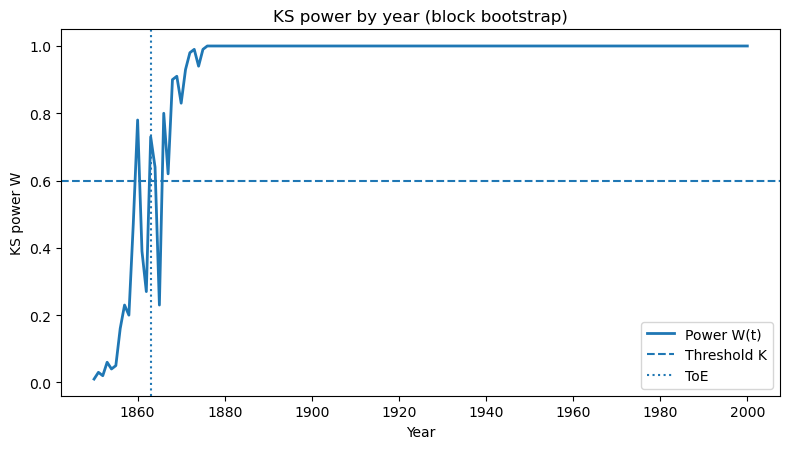

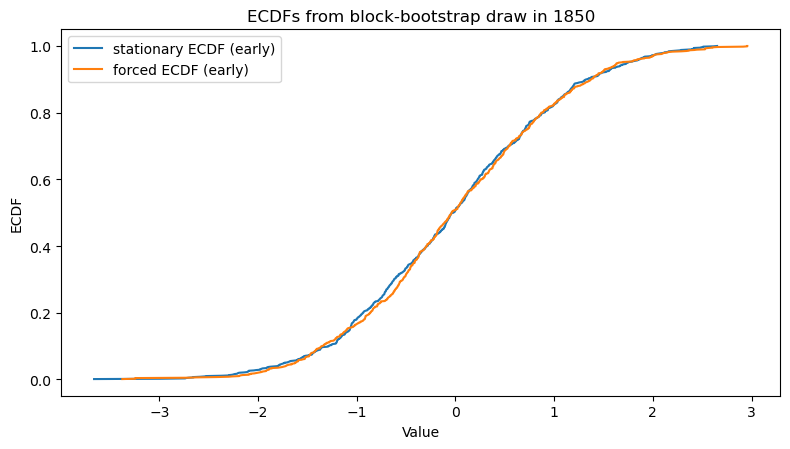

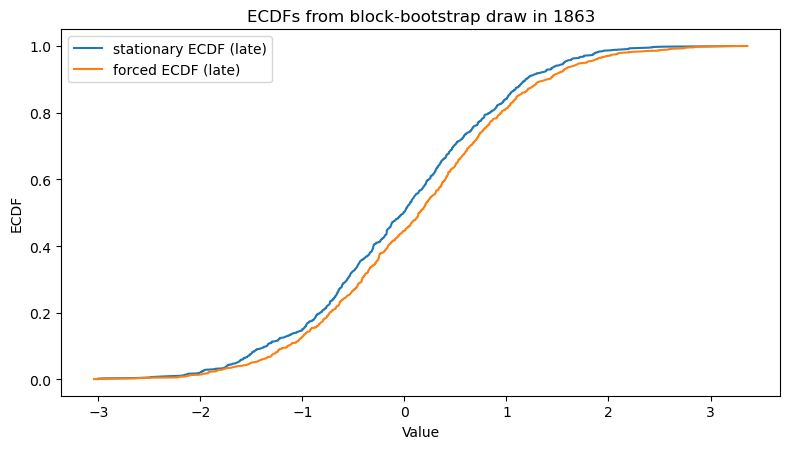

In [8]:
# KS power with circular BLOCK BOOTSTRAP, using scipy.stats.ks_2samp
# - Part A: ks_power_blockbootstrap(X, Y, ...) -> power
# - Part B: power_over_years(...) -> power(t) and ToE with persistence
#
# Swap the DEMO data with your series/pools.

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# ----------------------------
# Block bootstrap (circular)
# ----------------------------
def circular_block_bootstrap_sample(x: np.ndarray, n_out: int, block_len: int, rng=None):
    """Return a length-n_out sample from x using circular (wrap-around) blocks."""
    if rng is None:
        rng = np.random.default_rng()
    n = x.size
    if block_len < 1:
        raise ValueError("block_len must be >= 1")
    out_idx = []
    while len(out_idx) < n_out:
        start = int(rng.integers(0, n))
        blk = (start + np.arange(block_len)) % n
        out_idx.extend(blk.tolist())
    return x[np.asarray(out_idx[:n_out])]

# ----------------------------
# Part A: Power for one pair of series
# ----------------------------
def ks_power_blockbootstrap(
    X: np.ndarray,
    Y: np.ndarray,
    N2: int = 1000,
    R: int = 100,
    alpha: float = 0.01,
    block_len: int = 5,
    seed: int | None = 12345,
    alternative: str = "two-sided",
):
    """
    Estimate KS-test power via circular block bootstrap.
    Returns power (fraction of p<alpha).
    """
    rng = np.random.default_rng(seed)
    rejections = 0
    for _ in range(R):
        x_b = circular_block_bootstrap_sample(X, N2, block_len, rng)
        y_b = circular_block_bootstrap_sample(Y, N2, block_len, rng)
        stat, p = ks_2samp(x_b, y_b, alternative=alternative, mode="asymp")
        if p < alpha:
            rejections += 1
    return rejections / R

# ----------------------------
# Part B: Power over years + ToE
# ----------------------------
def power_over_years(
    baseline_pools: np.ndarray,
    forced_pools: np.ndarray,
    N2: int = 1000,
    R: int = 100,
    alpha: float = 0.01,
    block_len: int = 5,
    seed: int | None = 12345,
    K: float = 0.6,
    persist_years: int = 2,
    years: np.ndarray | None = None,
    alternative: str = "two-sided",
):
    """
    baseline_pools: shape (T, N1)  fixed-reference 'noise' per year
    forced_pools:   shape (T, N1)  signal+noise per year
    Returns power(t), ToE_year (or None).
    """
    T, N1 = baseline_pools.shape
    power = np.zeros(T, dtype=float)
    rng = np.random.default_rng(seed)

    for t in range(T):
        rejs = 0
        for _ in range(R):
            xb = circular_block_bootstrap_sample(baseline_pools[t], N2, block_len, rng)
            yb = circular_block_bootstrap_sample(forced_pools[t],   N2, block_len, rng)
            _, p = ks_2samp(xb, yb, alternative=alternative, mode="asymp")
            if p < alpha:
                rejs += 1
        power[t] = rejs / R

    # ToE with persistence
    toe_year = None
    if years is None:
        years = np.arange(T)
    streak = 0
    for i in range(T):
        if power[i] >= K:
            streak += 1
            if streak >= persist_years:
                toe_year = int(years[i - persist_years + 1])
                break
        else:
            streak = 0

    return power, toe_year

# ----------------------------
# ----- DEMO (synthetic) -----
# Replace this with your data.
# ----------------------------
SEED = 7
rng = np.random.default_rng(SEED)

# Make autocorrelated annual series by smoothing white noise
def smooth(v, w=7):
    return np.convolve(v, np.ones(w)/w, mode="same")

n_samples = 400
X_true = smooth(rng.normal(0, 1.0, n_samples), w=9)            # stationary baseline
Y_true = smooth(rng.normal(0, 1.0, n_samples), w=9) + 0.35      # forced (location shift)

# Part A: single power estimate
BLOCK_LEN = 5
N2 = 1000
R = 100
ALPHA = 0.01

power_one = ks_power_blockbootstrap(
    X_true, Y_true, N2=N2, R=R, alpha=ALPHA, block_len=BLOCK_LEN, seed=SEED
)
print(f"[Single] KS power (block bootstrap): {power_one:.3f}  | block_len={BLOCK_LEN}, N2={N2}, R={R}, alpha={ALPHA}")

# Part B: build year-wise pools and call ToE
START_YEAR = 1850
YEARS = np.arange(START_YEAR, START_YEAR + 151)  # 1850..2000
T = YEARS.size
N1 = 3000

# Stationary pools (fixed reference): not evolving in time
baseline_pools = rng.normal(0.0, 1.0, size=(T, N1))

# Forced pools: same variance, mean increases linearly
trend_per_year = 0.01
forced_pools = np.empty_like(baseline_pools)
for i, y in enumerate(YEARS):
    mu = (y - START_YEAR) * trend_per_year
    forced_pools[i] = rng.normal(mu, 1.0, size=N1)

K = 0.6
PERSIST = 2

power_t, toe_year = power_over_years(
    baseline_pools, forced_pools,
    N2=N2, R=R, alpha=ALPHA,
    block_len=BLOCK_LEN, seed=SEED,
    K=K, persist_years=PERSIST,
    years=YEARS
)

print(f"[Over years] ToE = {toe_year}  | K={K}, persist={PERSIST}")

# Plots
plt.figure(figsize=(8,4.6))
plt.plot(YEARS, power_t, linewidth=2, label="Power W(t)")
plt.axhline(K, linestyle="--", linewidth=1.5, label="Threshold K")
if toe_year is not None:
    plt.axvline(toe_year, linestyle=":", linewidth=1.5, label="ToE")
plt.xlabel("Year"); plt.ylabel("KS power W")
plt.title("KS power by year (block bootstrap)")
plt.legend(); plt.tight_layout(); plt.show()

# ECDFs from one bootstrap draw at an early vs late year
def ecdf(v):
    v = np.sort(v); n = v.size
    return v, np.arange(1, n+1)/n

early_i = 0
late_i  = np.clip((toe_year - START_YEAR) if toe_year is not None else 80, 0, T-1)

for i, tag in [(early_i, "early"), (late_i, "late")]:
    xb = circular_block_bootstrap_sample(baseline_pools[i], N2, BLOCK_LEN, rng)
    yb = circular_block_bootstrap_sample(forced_pools[i],   N2, BLOCK_LEN, rng)
    xv, xec = ecdf(xb); yv, yec = ecdf(yb)
    plt.figure(figsize=(8,4.6))
    plt.plot(xv, xec, label=f"stationary ECDF ({tag})")
    plt.plot(yv, yec, label=f"forced ECDF ({tag})")
    plt.xlabel("Value"); plt.ylabel("ECDF")
    plt.title(f"ECDFs from block-bootstrap draw in {YEARS[i]}")
    plt.legend(); plt.tight_layout(); plt.show()
